In [34]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
now = datetime.datetime.now()

In [3]:
train_df = pd.read_csv('dataset/train_01.csv')
test_df = pd.read_csv('dataset/test_01.csv')

In [4]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns='id')

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18
                                                   )

# RFC

In [6]:
def objective_rfc(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    
    param_rfc = {      
        'n_estimators': 1800,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 18,
        'n_jobs': 2
    }
    
    rfc = RandomForestClassifier(**param_rfc)
    scores = cross_validate(rfc, x, y, cv=skf)
    return scores['test_score'].mean()

In [7]:
%%time

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc, n_trials=800, n_jobs=4)
print(study_rfc.best_params)
print(study_rfc.best_value)
rfc_best_params = study_rfc.best_params

[I 2020-08-09 15:38:57,862] Finished trial#3 resulted in value: 0.928929889298893. Current best value is 0.928929889298893 with parameters: {'n_estimators': 1009, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}.
[I 2020-08-09 15:39:05,024] Finished trial#2 resulted in value: 0.9290036900369003. Current best value is 0.9290036900369003 with parameters: {'n_estimators': 1080, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 1}.
[I 2020-08-09 15:39:19,373] Finished trial#1 resulted in value: 0.9296309963099632. Current best value is 0.9296309963099632 with parameters: {'n_estimators': 1260, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}.
[I 2020-08-09 15:39:21,363] Finished trial#0 resulted in value: 0.9295571955719557. Current best value is 0.9296309963099632 with parameters: {'n_estimators': 1260, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf':

{'n_estimators': 1339, 'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 3}
0.9299261992619925
CPU times: user 1h 58min 38s, sys: 6min 53s, total: 2h 5min 31s
Wall time: 30min 36s


In [8]:
rfc = RandomForestClassifier(**rfc_best_params)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_leaf=3, min_samples_split=7,
                       n_estimators=1339)

In [9]:
train_score_rfc = rfc.score(x_train, y_train)
test_score_rfc = rfc.score(x_test, y_test)

rfc_p = rfc.predict(x_test)

acc_rfc = accuracy_score(rfc_p, y_test)
auc_rfc = roc_auc_score(rfc_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rfc, test_score_rfc))
print('acc:{}, auc:{}'.format(acc_rfc, auc_rfc))

train score:0.9319451765946231, test_score:0.9307503075030751
acc:0.9307503075030751, auc:0.9242679048002047


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


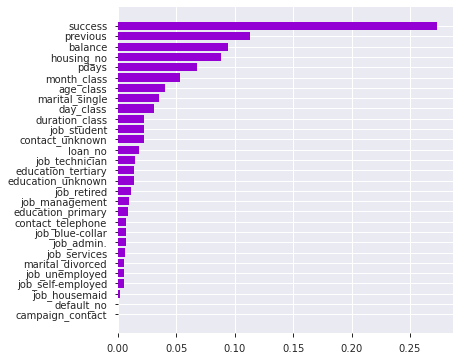

In [10]:
features = x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [11]:
rfc_name = 'models/rfc_' + now.strftime('%d_%H%M') + '.sav'
pickle.dump(rfc, open(rfc_name, 'wb'))

# XGB

In [12]:
def objective_xgb(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    
    param_xgb ={
        'eval_metric': 'auc',
        'eta': trial.suggest_uniform('eta', 0.01, 0.05),
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_uniform('subsample', 0.3, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.4),
        'alpha': trial.suggest_uniform('alpha', 1e-5, 1e-2),
        'seed': 18,
        'tree_method': 'gpu_hist',
        'n_jobs': 2
    }
    
    xgb = XGBClassifier(**param_xgb)
    scores = cross_validate(xgb, x, y, cv=skf)
    return scores['test_score'].mean()

In [13]:
%%time

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=800, n_jobs=4)
print(study_xgb.best_params)
print(study_xgb.best_value)
xgb_best_params = study_xgb.best_params

[I 2020-08-09 16:10:44,664] Finished trial#3 resulted in value: 0.9291143911439115. Current best value is 0.9291143911439115 with parameters: {'eta': 0.012112176057233835, 'n_estimators': 1480, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6559504029241079, 'colsample_bytree': 0.946125947678468, 'gamma': 0.062364500468174947, 'alpha': 0.0009851520184147502}.
[I 2020-08-09 16:10:53,826] Finished trial#0 resulted in value: 0.928929889298893. Current best value is 0.9291143911439115 with parameters: {'eta': 0.012112176057233835, 'n_estimators': 1480, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6559504029241079, 'colsample_bytree': 0.946125947678468, 'gamma': 0.062364500468174947, 'alpha': 0.0009851520184147502}.
[I 2020-08-09 16:11:31,774] Finished trial#2 resulted in value: 0.9288560885608856. Current best value is 0.9291143911439115 with parameters: {'eta': 0.012112176057233835, 'n_estimators': 1480, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.655950402924107

{'eta': 0.011334728590763078, 'n_estimators': 931, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5122903067421056, 'colsample_bytree': 0.624561763436076, 'gamma': 0.26358882248656373, 'alpha': 0.003997717499339201}
0.9296309963099632
CPU times: user 3h 9min 25s, sys: 5min 39s, total: 3h 15min 4s
Wall time: 34min 3s


In [14]:
xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(x, y)

XGBClassifier(alpha=0.003997717499339201, base_score=0.5, booster=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.624561763436076, eta=0.011334728590763078,
              gamma=0.26358882248656373, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.0113347284,
              max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=931, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.00399771752,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5122903067421056,
              tree_method=None, validate_parameters=False, verbosity=None)

In [15]:
train_score_xgb = xgb_model.score(x_train, y_train)
test_score_xgb = xgb_model.score(x_test, y_test)

xgb_p = xgb_model.predict(x_test)

acc_xgb = accuracy_score(xgb_p, y_test)
auc_xgb = roc_auc_score(xgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))
print('acc:{}, auc:{}'.format(acc_xgb, auc_xgb))

train score:0.9315234580917238, test_score:0.931119311193112
acc:0.931119311193112, auc:0.9085410443116753


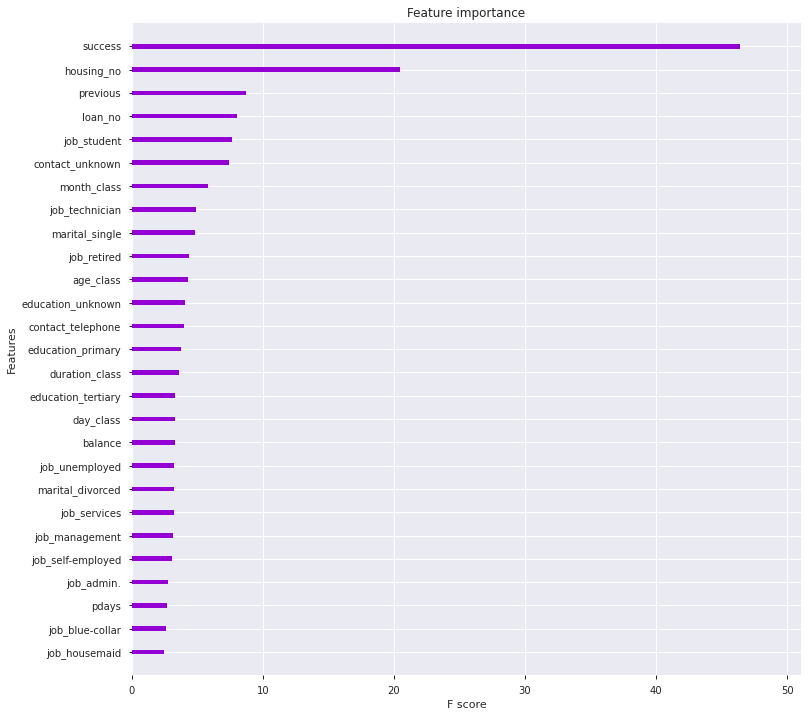

In [28]:
_, ax = plt.subplots(figsize=(16, 16))
xgb.plot_importance(xgb_model,
                    ax=ax,
                    importance_type='gain',
                    color='darkviolet',
                    show_values=False)
plt.show()

# LGB

In [33]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

In [38]:
def objective_lgb(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    
    params_lgb = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1200,
        # 'early_stopping_rounds': 100,
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.08),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_uniform('subsample', 0.3, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 35),
        'feature fraction': trial.suggest_uniform('feature fraction', 0.80, 0.95),
        'random_state': 18,
        'n_jobs': 2
    }
                          
    lgb = LGBMClassifier(**params_lgb)
    scores = cross_validate(lgb, x, y, cv=skf)
    return scores['test_score'].mean()     

In [39]:
%%time

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=800, n_jobs=4)

print(study_lgb.best_params)
print(study_lgb.best_value)
lgb_best_params = study_lgb.best_params

[I 2020-08-09 21:15:00,985] Finished trial#1 resulted in value: 0.9287453874538747. Current best value is 0.9287453874538747 with parameters: {'learning_rate': 0.04789220689470043, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.33204603646904457, 'colsample_bytree': 0.9446194271483829, 'min_data_in_leaf': 34, 'feature fraction': 0.9303519664722509}.
[I 2020-08-09 21:15:08,291] Finished trial#3 resulted in value: 0.927490774907749. Current best value is 0.9287453874538747 with parameters: {'learning_rate': 0.04789220689470043, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.33204603646904457, 'colsample_bytree': 0.9446194271483829, 'min_data_in_leaf': 34, 'feature fraction': 0.9303519664722509}.
[I 2020-08-09 21:15:10,299] Finished trial#2 resulted in value: 0.9247232472324723. Current best value is 0.9287453874538747 with parameters: {'learning_rate': 0.04789220689470043, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.33204603646904457, 'colsample_bytree': 0.9446194

{'learning_rate': 0.022301320613238612, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7952291814670439, 'colsample_bytree': 0.6138894862114016, 'min_data_in_leaf': 33, 'feature fraction': 0.8275059872366581}
0.9296678966789667
CPU times: user 2h 30min 43s, sys: 19min 28s, total: 2h 50min 11s
Wall time: 30min 13s


In [40]:
lgb_model = LGBMClassifier(**lgb_best_params)
lgb_model.fit(x, y)

LGBMClassifier(colsample_bytree=0.6138894862114016,
               feature fraction=0.8275059872366581,
               learning_rate=0.022301320613238612, max_depth=3,
               min_child_weight=1, min_data_in_leaf=33,
               subsample=0.7952291814670439)

In [41]:
train_score_lgb = lgb_model.score(x_train, y_train)
test_score_lgb = lgb_model.score(x_test, y_test)

lgb_p = lgb_model.predict(x_test)

acc_lgb = accuracy_score(lgb_p, y_test)
auc_lgb = roc_auc_score(lgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_lgb, test_score_lgb))
print('acc:{}, auc:{}'.format(acc_lgb, auc_lgb))

train score:0.9298365840801265, test_score:0.9302583025830258
acc:0.9302583025830258, auc:0.9220031934033673


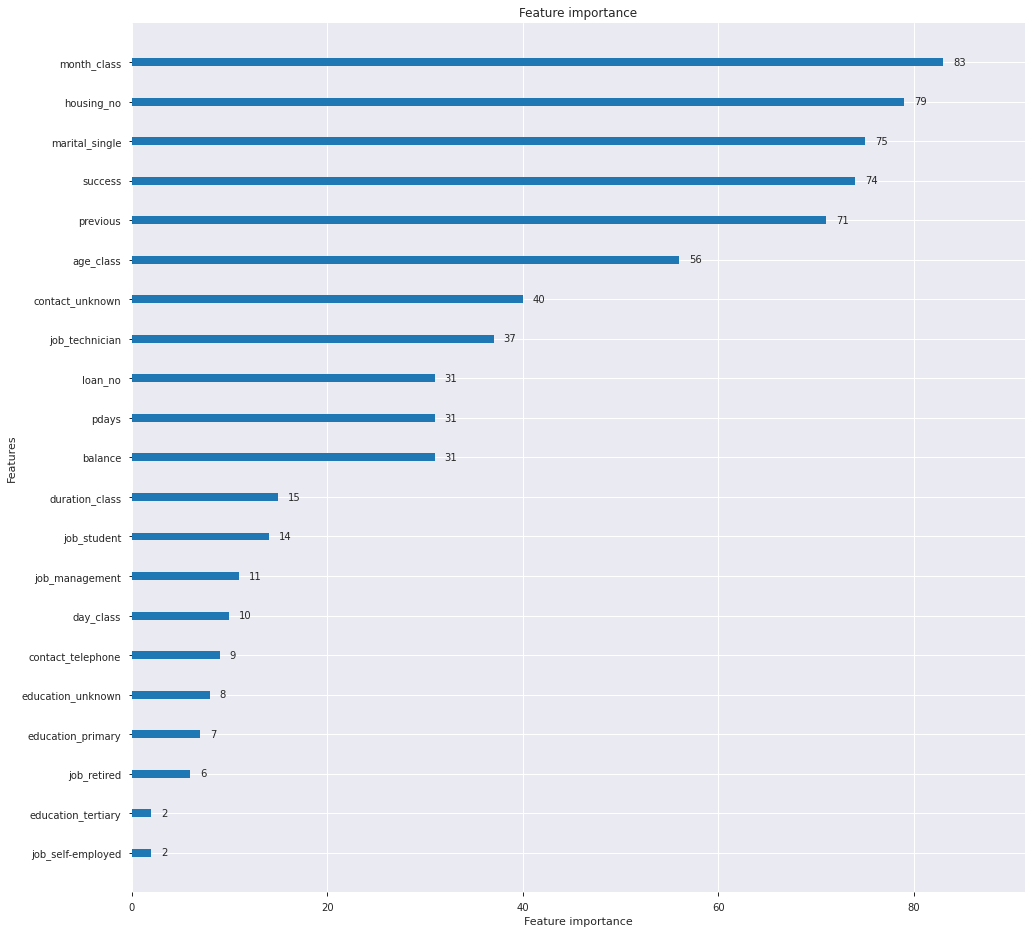

In [42]:
lgb.plot_importance(lgb_model, figsize=(16,16))

# CB

In [18]:
params_cab = {
    'iterations':1000,
    'custom_loss':['Accuracy'],
    'early_stopping_rounds':50,
}

In [19]:
cab = CatBoostClassifier(**params_cab)

cab.fit(x_train, y_train)

Learning rate set to 0.036197
0:	learn: 0.6523841	total: 74.5ms	remaining: 1m 14s
1:	learn: 0.6157785	total: 80.7ms	remaining: 40.3s
2:	learn: 0.5822001	total: 88.7ms	remaining: 29.5s
3:	learn: 0.5516569	total: 97ms	remaining: 24.2s
4:	learn: 0.5241587	total: 104ms	remaining: 20.7s
5:	learn: 0.4981506	total: 110ms	remaining: 18.2s
6:	learn: 0.4732370	total: 119ms	remaining: 16.8s
7:	learn: 0.4524919	total: 125ms	remaining: 15.5s
8:	learn: 0.4329606	total: 132ms	remaining: 14.6s
9:	learn: 0.4158419	total: 139ms	remaining: 13.8s
10:	learn: 0.4007643	total: 146ms	remaining: 13.1s
11:	learn: 0.3866430	total: 152ms	remaining: 12.5s
12:	learn: 0.3752579	total: 158ms	remaining: 12s
13:	learn: 0.3637828	total: 165ms	remaining: 11.6s
14:	learn: 0.3532122	total: 171ms	remaining: 11.2s
15:	learn: 0.3419082	total: 179ms	remaining: 11s
16:	learn: 0.3320476	total: 185ms	remaining: 10.7s
17:	learn: 0.3230439	total: 191ms	remaining: 10.4s
18:	learn: 0.3158758	total: 197ms	remaining: 10.2s
19:	learn: 0

In [20]:
train_score_cab = cab.score(x_train, y_train)
test_score_cab = cab.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_cab, test_score_cab))

train score:0.9430152872957301, test_score:0.9281672816728167


## submit

In [48]:
pred_rfc = rfc.predict(test_df)
pred_xgb = xgb_model.predict(test_df)
pred_lgb = lgb_model.predict(test_df)
pred_cab = cab.predict(test_df)

In [54]:
pred = pd.DataFrame({
    'RandomForest': pred_rfc,
    'XGBoost': pred_xgb,
    'LigntGBM': pred_lgb,
    'CatBoost': pred_cab
})

pred['sum'] = pred.sum(axis=1)
pred['pred'] = [i/4 for i in pred['sum']]
pred.head()

,RandomForest,XGBoost,LigntGBM,CatBoost,sum,pred
0,1,1,1,1,4,1.0
1,0,0,0,0,0,0.0
2,0,0,0,0,0,0.0
3,0,0,0,0,0,0.0
4,0,0,0,0,0,0.0


In [53]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})


now = datetime.datetime.now()
file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)